In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Tabular modeling takes data in the form of a table:
- the objective is to predict the value in one column based on the values in the other columns.
- look more general Machine Learning techniques : random forest
- preprocess and clean the data
- interpret the result of our models after training
- feed columns that contain categories into a model that expects numbers by using embedding

## Categorical Embeddings
In tabular data:
- some contains -> numerical data: age (directly fed to the model) => continuous variables
- other contains -> string values: sex (need to converted to numbers) => 
Those correspond to different categories, categorical variables

Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, defines a distance measure for categorical variables, it can be used for visualizing categorical data and for data clustering.

Embedding layer == an ordinary linear layer after every one-hot-encoded input layer.

## Beyond Deep Learning
the vast majority of datasets can be best modeled with just two methods:
- Ensembles of decision trees( random forests and gradient boosting machines), for structured data: database table at most companies
- Multilayered neural networks learned with SGD(shallow and/or deep learning),
unstructured data: audio, images, and natural language

The critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. The exception to this guideline is when the dataset meets one of these conditions:
- There are some high-cardinality categorical variables that are very important.
- There are some columns that contain data that would be best understood with a neural network
In practice, when we deal with datasets that meet these exceptional conditions, we always try both decision tree ensembles and deep learning to see which works best.

In practice, things tends to be less cut-and-dried, and there will often be a mixture of high- and low-cardinality categorical variables and continuous variables.

Decision trees don't depend on mat. mul. and derivatives kinda operations, so PyTorch isn't much use. Instead, largely relying on a library called scikit-learn

## The Dataset
Blue Book for Bulldozers Kaggle competition: 
- predict the sale price of a particular piece of heavy equipment at auction based on:
    - usage
    - equipment type
    - configuration

In [3]:
creds = '{"username":"asmikarmarah","key":"a1175ff031bc5b2169daf18cc4c63ab5"}'

In [4]:
# then execute this cell:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

In [5]:
# pick a path to download the dataset to:
path = URLs.path('bluebook')
path

Path('C:/Users/Kushan/.fastai/archive/bluebook')

In [6]:
Path.BASE_PATH = path

In [7]:
# use the Kaggle API to download the dataset to that path and extract it:

if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

In [8]:
# gone to file then extract there
path.ls(file_type='test')

(#16) [Path('bluebook-for-bulldozers.zip'),Path('Data Dictionary.xlsx'),Path('Machine_Appendix.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('to.pkl'),Path('Train.7z'),Path('Train.zip'),Path('TrainAndValid.7z')...]

### Look at the Data
Kaggle Data page explains that the keys fields in train.csv are as follows:
- SalesID
- MachineID
- saleprice
- saledate
It's important to look at your data directly to understand the format

Start by reading the training set into a Pandas DataFrame, it's good idea to specify low_memory=False unless Pandas actually runs out of memory and returns an error.

In [9]:
# load our data and have a look at the columns:

df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

Try looking through the dataset to get what kind of information is in each one.

Next step is to handle _ordinal columns_(containings strings or similar, but where those strings have a natural ordering).

In [10]:
# levels of ProductSize:

df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [11]:
# tell Pandas about a suitable ordering of these levels like so:

sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

- The most important data column is the dependent variable.
- selecting metric is an important part of the project setup: Kaggle tells what metric to use:
    - the root mean squared log error (RMLSE) between the actual and predicted auction prices.

In [12]:
# need little processing
# take the log of the prices
# then m_rmse:

dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

## Decision Tree
A decision tre asks a series of binary (yes or no) questions about the data. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required. 

This sequence of questions is now a procedure:
- taking any data item, whether item from the training set or a new one
- assigning that item to a group, after asking + answering the questions

The goal of our model is to predict values for items, not to assign. The value is that we can now assign a prediction value for each of these groups(for regression, we take the target mean of the items in the group)

find the right questions to ask:
1. Loop through each column of the dataset in turn.
2. For each column, loop through each possible level of that column in turn.
3. Try splitting the data into two groups, based on:
    - continous var: greater than or less than
    - categorical var: equal to or not equal to that level
4. Find the average sale price for each of those groups, very simple "model" in which our predictions are simply the average sale price of the item's group.
5. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
6. Treat each group as a separate dataset, and find the best split for each by going back to step1 for each group.
7. Continue this process recursively, until reached some stopping criterion for each group.

### Handling Dates
Help algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another.

We replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

In [13]:
# fastai comes with a func
# have to pass a column that contains dates:

df = add_datepart(df, 'saledate')

In [14]:
# do the same for the test set while we're there:

df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [15]:
# we can see that there are now lots of new columns in our DataFrame:

' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Using TabularPandas and TabularProc
A second peice of perparatory processing is to be sure be we can handle strings and missing data. We use fastai's class:
- TabularPandas, which wraps a Pandas DF and provides a few conveniences.
- To populate a TabularPandas, we will use two TabularProcs, Categorify and FillMissing.
A TabularProc == regular Transform, execpt for the following:
- It returns the exact same object that's passed to it after modifying the object in place.
- It returns the transform once, when data is first passed in, rather than lazily as the data is accessed.

Categorify: a TabularProc that replaces a column with a numeric categorical column.

FillMissing: a TablarProc that replaces missing values with the median of the column, and creates a new Boolean column that is set to True for any row where the value was missing.

In [16]:
# good starting point for data processing:

procs = [Categorify, FillMissing]

TabularPandas will also handle splitting the dataset into training and validation sets.

We want the validation set to be later in time than the training set. Kaggle training data ends in April 2012, So define training dataset that contains training data before Nov 2011, and validation set consisting of data from after Nov 2011.

In [17]:
# use np.where, a useful function that returns the indices of all True values:

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

In [18]:
# TabularPandas needs to be told which columnss are continuous and which are categorical
# handle that automatically using helper function cont_cat_split:

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [19]:
# TabularPandas behaves as fastai Datasets object, including providing train and valid attributes:

len(to.train),len(to.valid)

(404710, 7988)

In [20]:
# data is still displayed as strings for categories:

to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [21]:
# the underlying items are all numeric:

to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


The convesion of categorical columns to numbers is done by simply replacing each unique level with a number.

In [22]:
# we can see the mapping by looking at the classes attribute:

to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

we should save it : that way, we can continue our work from here without rerunning the previous steps.

In [25]:
# fastai provides a save method that uses Python's pickle system to save nearly any Python object:

(path/'to.pkl').save(to)

AttributeError: 'WindowsPath' object has no attribute 'save'

In [23]:
save_pickle(path/'to.pkl',to)

In [24]:
to1 = load_pickle(path/'to.pkl')

### Creating the Decision Tree

In [25]:
to = load_pickle(path/'to.pkl')

In [26]:
# to begin, we define our independent and dependent variables:

xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [27]:
# data is all numberic, no missing values, we can create a decision tree:

m = DecisionTreeRegressor(max_leaf_nodes=4)# told sklearn to create just 4 leaf nodes
m.fit(xs, y);

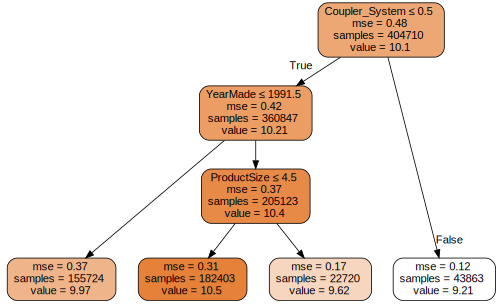

In [28]:
# display the tree:

draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

Understanding decision tree:

- The top node: 
    - the initial model before any splits have been done
    - simplest possible model
    - result of asking zero questions
    - pridict the value to be the average value of whole dataset
    - predicts a value of 10.1 for the logarithm of the sales price
    - MSE: 0.48
    - Square root: 0.69
    - decision criterion: split based on the coupler_system column
    
- Moving down left node:
    - 360847 auction records for equipment where coupler_system <= 0.5
    - the average value of dependent var: 10.21
- Moving down right node:
    - initial model takes us to the records where coupler_system > 0.5
- The bottom row contains our leaf nodes:
    - no answer coming out of no question
    
We can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups that differ in value significantly.

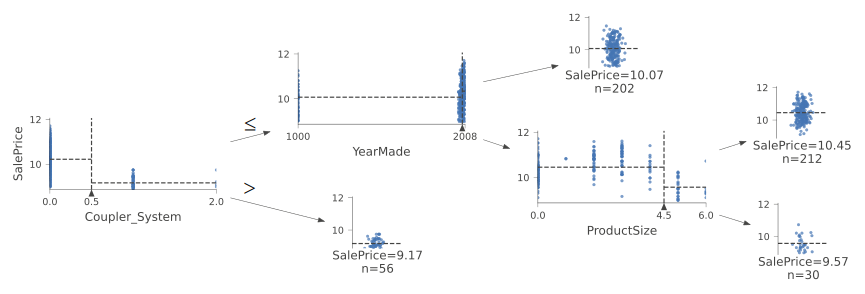

In [29]:
# show the same info using Terence Parr's dtreeviz library:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVU Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Clearly see that there's a problem with our YearMade data: there are bulldozers made in the year 1000, this is a missing code. For modeling purposes, 1000 is fine but this outlier makes visualizing the values we are interested in more difficult.

In [30]:
# replace it with 1950:

xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

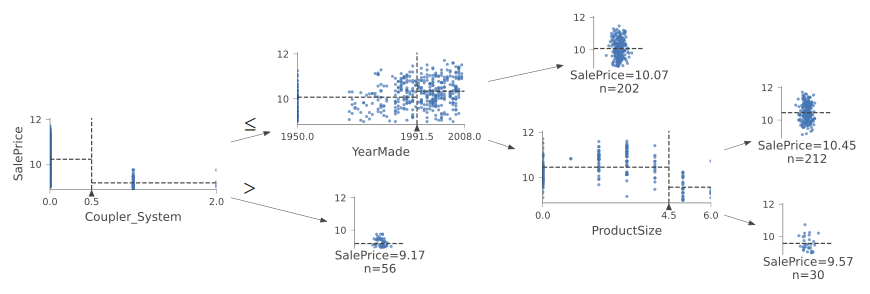

In [31]:
# that change makes the split much clearer in the tree visualization
# doesn't change the result of the model in any significant way:

m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [32]:
# the decision tree algorithm build a bigger tree
# we are not passing in any stopping criteria such as max_leaf_nodes:

m = DecisionTreeRegressor()
m.fit(xs, y);

In [33]:
# function to check rmse of our model:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

m_rmse(m, xs, y)

0.0

In [34]:
# now check the validation set, to ensure we're not overfitting:

m_rmse(m, valid_xs, valid_y)

0.334935

In [35]:
# it looks like we might be overfitting, here's why:

m.get_n_leaves(), len(xs)

(324560, 404710)

sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node.

In [36]:
# change the stopping rule to ensure every leaf node contains at least 25 auction records:

m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323339)

In [37]:
# check the number of leaves again:

m.get_n_leaves()

12397

Building a decision tree is a good way to create a model:
- flexible
- handle nonlinear relationships
- interactions between variables
- there is a fundamental compromise between how well it generalizes(by creating small trees)
- how accurate it is on the training set(by using large trees)

### Categorical Variables
We deal with categorical variables by 
- one-hot encoding them
- feeding them to an embedding layer: help the model to discover the meaning of the different levels of these variables

In decision tree, we don't have embedding layers.

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. But it does end up making dataset harder to work.

## Random Forests
Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated perdictor. The aggregation averages over the versions. Here is the procedure that Breiman is proposing:
1. Randomly choose a subset of the rows of your data.
2. Train a model using this subset.
3. Save that model, and then return to step 1 a few times.
4. This will give multiple trained model. To make a prediction, predict using all of the models, and then the average of each of those model's predictions.

Different model give different errors and avg of all the errors is zero. So average of all the model's predictions is closer and closer to the correct answer.

When applied to decision tree building algorithms, by
- randomly selected from a subset of columns when choosing each split in each decision tree: random forest.

Bagging is a particular approach to ensembling, or combinin the results of multiple models together.

### Creating a Random Forest
Create a random forest just like we created a decision tree, except now we are also specifying parameters that indicate:
- n_estimators : the number of trees
- max_samples: how many rows to sample for training each tree
- max_features: how many columns to sample at each split point
- min_samples_leaf: specify when to stop splitting the tree nodes
- n_jobs=-1: to tell sklearn to use all our CPUs to build the trees in parallel

In [38]:
# creating a little function for this:

def rf(xs, y, n_estimators=40, max_samples=200_000,
      max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

m = rf(xs, y);

In [39]:
# our validation RMSE is now much improved over our last result produced by the DecisionTreeRegressor:

m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170966, 0.232699)

The random forest aren't very sensitive to the hyperparameter choices, set n_estimators to as high a number as you have time to train => more trees == more accurate model

In [40]:
# to see the impact of n_estimators
# get the predictions from each individual tree in our forest:

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [41]:
# preds.mean(0) gives the same results as our random forest:

r_mse(preds.mean(0), valid_y)

0.232699

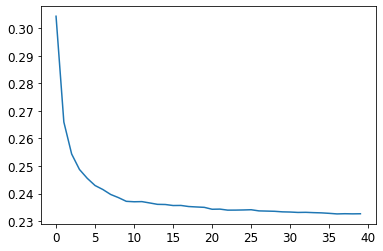

In [42]:
# RMSE when we add more trees, improveement levels off quite a bit after around 30 trees:

plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error
The OOB error is a way of measuring prediction error in the training dataset by including in the calculation of a row's error trees only where that row was not included in training.

This is beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validatino set

In [43]:
# compare them to the training labels, being calculated on trees using the training set:

r_mse(m.oob_prediction_, y)

0.210776

OOB error < validation set error = something else causing that error, normal generalization error

## Model Interpretation
- how confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purpose of prediction?
- How do predictions vary as we vary these columns?

### Tree Variance for Prediction Confidence
use the standard deviation of predictions across the trees, instead the mean: for the relative confidence of predictions
- higher standard deviations: results for rows where trees give very different results
- lower standard deviations: compared to cases where they are more consistent

In [44]:
# get predictions over the validation set, for each tree in the forest:

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 7988)

Now we have a predictions for every tree(40) and every auction(7988) in the validation set

In [45]:
# we can get std deviation of the predictions over all the trees, for each auction:

preds_std = preds.std(0)

In [46]:
# std dev. for the predictions for the first five auction(1st 5 rows) of validation set:

preds_std[:5]

array([0.26069358, 0.10409366, 0.09904178, 0.27184634, 0.13110276])

- low std dev.: trees agree
- high std dev.: trees don't agree

### Feature Importance
The feature importance give us insight of how a model making predictions.

In [47]:
# a simple function we can use to pop them into a DataFrame and sort them:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest

In [48]:
# YearMade adnn ProductSize being at the top of the list:

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.173023
6,ProductSize,0.117253
30,Coupler_System,0.117053
7,fiProductClassDesc,0.073112
54,ModelID,0.054777
65,saleElapsed,0.048835
3,fiSecondaryDesc,0.046104
31,Grouser_Tracks,0.041196
12,Enclosure,0.040495
32,Hydraulics_Flow,0.032725


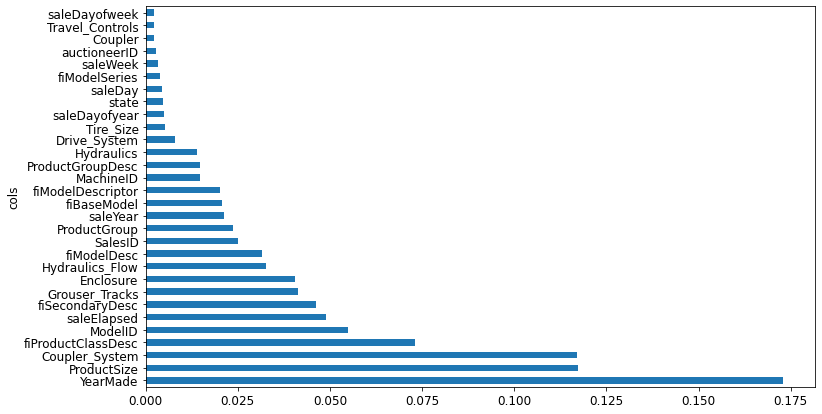

In [49]:
# a plot of the feature importances shows the relative importances more clearly:

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The feature importance algorithm:
- loops through each tree
- then recursively explores each branch
- looks what feature was used for that split
- how much the model improves as a result of that split
- the improvement is added to the importance score for that feature
- summed across all branches of all trees
- scores are normalized such that they add to 1

### Removing Low-Importance Variables

In [51]:
# keep those feature importance greater than 0.005:

to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [52]:
# retrain our model using just this subset of the columns:

xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

In [53]:
# result:

m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18131, 0.230503)

In [54]:
# accuracy is about the same, but we have fewer columns to study:

len(xs.columns), len(xs_imp.columns)

(66, 21)

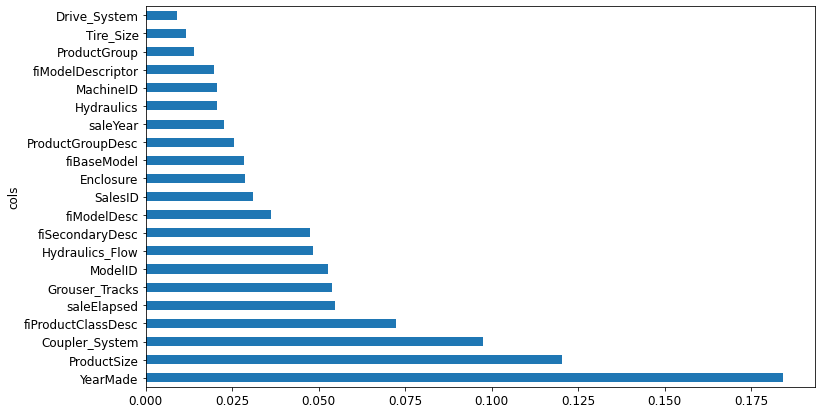

In [55]:
# also makes feature importance plot easier to interpret:

plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features
similar meanings: ex: ProductGroup and ProductGroupDesc

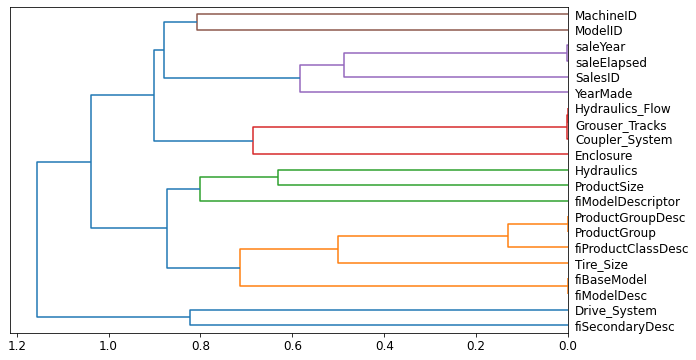

In [56]:
# start with this:

cluster_columns(xs_imp)

The pair columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. For example:
- ProductGroup and ProductGroupDesc
- saleYear and saleElapsed
- fiModelDesc and fiBaseModel

merged quite early, they are practically synonyms for each other.

Try removing some of these closely related features to see if the model can be simplified without impacting the accuracy.

In [57]:
# create a function that quickly trains a random forest and return OOB score:

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [58]:
# our baseline:
get_oob(xs_imp)

0.8781576734893485

In [61]:
# removing each of our potentially redundant variables:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8764092839302421,
 'saleElapsed': 0.8723696363027629,
 'ProductGroupDesc': 0.8775660792436881,
 'ProductGroup': 0.8777744982284726,
 'fiModelDesc': 0.8753064150498373,
 'fiBaseModel': 0.8767063822863265,
 'Hydraulics_Flow': 0.8778220141943579,
 'Grouser_Tracks': 0.8772553248167918,
 'Coupler_System': 0.87743935807579}

In [62]:
# try dropping multiple variables:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8736851273406069

Not much worse than the model with all the fields

In [63]:
# create DataFrames without these columns, and save them:

xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [64]:
# load them back later:

xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [65]:
# check our RMSE again, to confirm that the accuracy hasn't substantially changed:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183236, 0.23318)

### Partial Dependence
Two important predictors are ProductSize and YearMade. We'd like to understand the relationship between these predictors and sale price.

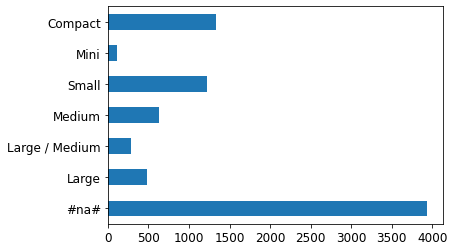

In [66]:
# first check the count of values per category, how common each category is:

p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

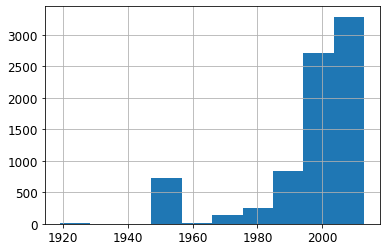

In [67]:
# same for YearMade, histogram for numeric features:

ax = valid_xs_final['YearMade'].hist()

Other than the special value 1950, which we used for coding missing year values, most of the data is from after 1990.

Partial dependence plots answer the question: if a row varied on nothing other than the feature in question, how it impact the dependent variable?

Q: How does YearMade impact sale price, all other things being equal?
- Ans: replace every single value in the YearMade column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do same for 1951, 1952,..., 2011. This isolates the effect of only YearMade.

With these avgs, we can then plot x-axis: each year, y-axis: each prediction

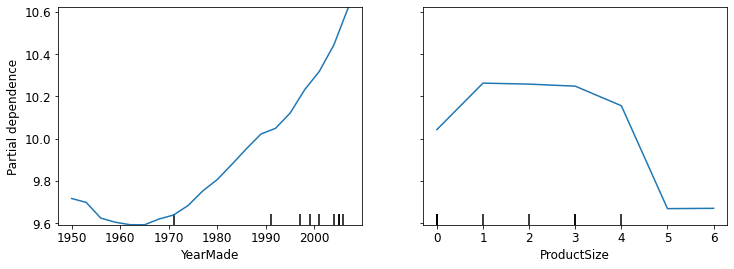

In [68]:
# let's take a look, on partial dependence plot:

from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade', 'ProductSize'],
                       grid_resolution=20, ax=ax)

- YearMade partial plot:
    - section covering after 1965, nearly linear relationship between year and price. There is an exponential inc. in price(after taking the logrithm)
    - depreciation is generally recognized as being a multiplicative factor over time, varying the year made ought to show an exponential relationship with sale price.
    
- ProductSize partial plot:
    - It shows that the final group, which we saw is for missing values, has the lowest price. 
    - Missing values can sometimes be useful predictors - it entirely depends on what causes them to be missing.

### Data Leakage
A trivial example of leakage would be a model that uses the target itself as an input(it rains on rainy days). The introduction of this illegitimate information is unintentional, and facilitated by the data collection, aggregation, and preparation process.

Data leakage is subtle ad can take many forms. Missing values often represent data leakage.

Jeremy used a random forest to model the data, then used feature importance to find out which features were most predictive. He noticed:
- The model was able to correctly predict who would receive grants over 95% of the time.
- Apparently meaningless identifier columns were the most important predictors.
- The day of week and day of year columns were also highly predictive; for instance, the vast majority of grant applications dated on a Sunday were accepted, and many accepted grant applications were dated on January 1.

Partial dependence plot showed that when the information was missing. It turned out that, the university filled out much of this information only after a grant application was accepted and for applications that were not accepted, it was just left blank. - it was data leakage

This example showcases the most practical and simple approaches to identifying data leakage, which are to build a model and then do the following:
- check whether the accuracy of the model is too good to be true.
- look for important predictors that don't make sense in practice.
- look for partial dependence plot results that don't make sense in practice.

### Tree Interpreter
For predicting with a particular row of data, what were that most important factors and how did they influence that prediction?
- Ans: we need to use the treeinterpreter library and also use the waterfallcharts library to draw the chart of the results

In [69]:
!pip install treeinterpreter
!pip install waterfallcharts

In [70]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Compute feature importances across the entire random forest: look at the contribution of each variable to improving the model

In [71]:
# pick first few rows of our validation set:

row = valid_xs_final.iloc[:5]

In [72]:
# then pass these to treeinterpreter:

prediction,bias,contributions = treeinterpreter.predict(m, row.values)

- Prediction: prediction that the random forest makes
- bias: is the prediction based on taking the mean of the dependent variable
- contributions: the total change in prediction due to each of the independent variables.

contributions.sum() + bias = prediction

In [73]:
prediction[0], bias[0], contributions[0].sum()

(array([9.87753363]), 10.104879498185275, -0.22734586823449318)

the clearest way to display the contributions is with a waterfall plot.

How positive and negative contributions from all the independent variables sum up to create the final prediction

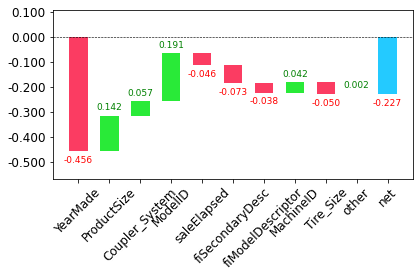

In [74]:
# final prediction is the column labeled "net" here:

waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
         rotation_value=45, formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development.

## Extrapolation and Neural Networks
A problem with random forests, like all machine learning or deep learning algorithms, they don't always generalize well to new data. So, first look at the extrapolation problem that random forests have and how they can help identify out-of-domain data

### The Extrapolation Problem

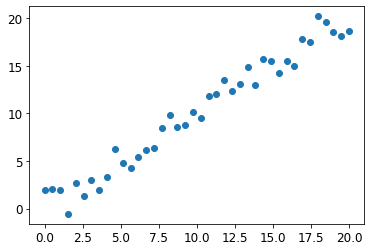

In [75]:
# making predictions from 40 data points showing a slightly noisy linear relationship:

x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

We have to turn our vector into a matrix with one column because sklearn expects a matrix of independent vars, not a single(independent var) vector.

In [76]:
# change the shape from [40] to [40,1]:
xs_lin = x_lin.unsqueeze(1) # adds a new unit axis to a tensor at the requested dimension
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [77]:
# a more flexible approach is to slice an array with the special value None:
x_lin[:, None].shape

torch.Size([40, 1])

In [78]:
# now create a random forest for this data
# use only first 30 rows to train the model:

m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

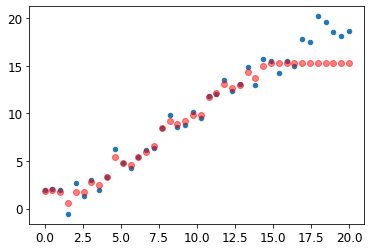

In [79]:
# test the model on the full dataset:
# blue dots: training data
# red dots: predictions

plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

Problem: Our predictions outside the domain that our training data covered are all too low. Why?
- A random forest averages the predictions of a number of trees. And a tree predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside the range of the training data.

This is problematic for data indicating a trend over time:
- inflation
- for a future time

Random forest are not able to extrapolate outside the types of data they have seen. so make sure validation set does not contain out-of-domain data.

### Finding Out-of-Domain Data
In this case, we don't use the random forest to predict our actual dependent variable, instead predict whether a row is in the validation set or the training set.

In [80]:
# combine our training and validation sets:
df_dom = pd.concat([xs_final, valid_xs_final])
# create a dependent var that represents which dataset each row comes from:
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

# build a random forest using that data:
m = rf(df_dom, is_valid)
# get its feature importance:
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.890441
10,SalesID,0.072936
13,MachineID,0.031307
0,YearMade,0.001362
4,ModelID,0.000805
14,Hydraulics,0.000628


three columns differ significantly between the training and validation sets:
- saleElapsed: it's the number of days bet the start of the dataset and each row
- SalesID: identifiers for auction sales might increment over time
- MachineID: something similar might be happening for individual items sold in those auctions.

In [82]:
# get a baseline of the original random forest model's RMSE:

m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

orig 0.232807


In [83]:
# then determine the effect of removing each of these columns in turn:

for c in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

SalesID 0.23036
saleElapsed 0.23484
MachineID 0.23037


In [89]:
# looks like we should be able to remove SalesID and MachineID without losing accuracy:

time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228888

Removing variables has slightly 
- improved the model's accuracy
- make it more resilient over time
- easier to maintain and understand

One more thing help in our case is to avoid old data

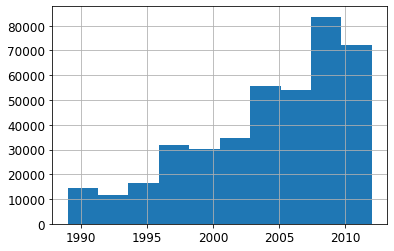

In [90]:
# lets try using the most recent few years of the data:

xs['saleYear'].hist();

In [91]:
# here's the result of training on this subset:

filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177839, 0.229907)

### Using a Neural Network

In [92]:
# first replicate the steps we took to set up the TabularPandas object:

df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [94]:
# leverage the by trimming unwanted columns in the random forest by using the same set of columns for our nn:

df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled differently in NN(using embeddings). To create embeddings, fastai needs to determine which columns should be treated as categorical variables.

Comparing the number of distinct levels in the variable to the value of the max_card parameter. If it's lower, fastai treat as Categorical

In [105]:
# use 9000 as max_card value:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

saleElapsed doesn't be treated as categorical, but we want to able to predict auction sale prices in the future

In [115]:
# make this a continous variable:

cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [116]:
# let's take a look at the cardinality of each of the categorical variables:

df_nn_final[cont_nn].nunique()

saleElapsed    4013
dtype: int64

Two variables pretaining to the "model" of the equipment, both with similar high cardinalities = similar redundant info

Having a columns with 5000 levels means needin 5000 columns in our embedding matrix, which would be nice to avoid if possible

In [119]:
# see impact of removing one of these model columns has on random forest:

xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176766, 0.230022)

In [120]:
# minimal impact, so remove it as a predictor for our neural network:

cat_nn.remove('fiModelDescriptor')

In [121]:
# add the Normalize processor when we build our TabularPandas object:

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                     splits=splits, y_names=dep_var)

In [122]:
# tabular models and data don't generally require much GPU RAM, so use larger batch sizes:

dls = to_nn.dataloaders(1024)

In [123]:
# its good to set y_range for regression models, find min and max of our dependent var:

y = to_nn.train.y
y.min(), y.max()

(8.465899467468262, 11.863582611083984)

For tabular data fastai creates a NN with two hidden layers with 200 and 100 activations, works well for small datasets but here we got large dataset.

SuggestedLRs(valley=0.0002290867705596611)

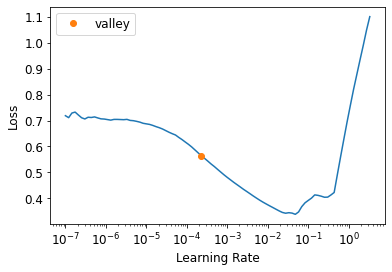

In [124]:
# we inc. the layer size to 500 and 250:

learn = tabular_learner(dls, y_range=(8, 12), layers=[500,250],
                       n_out=1, loss_func=F.mse_loss)

learn.lr_find()

In [125]:
# no need to use fine_tune, so train with fit_one_cycle for a few epochs:

learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062918,0.063494,00:52
1,0.053875,0.054559,00:53
2,0.047639,0.059280,00:52
3,0.043462,0.050678,00:52
4,0.040295,0.050489,00:53


In [126]:
# use our r_mse func to compare the result to the random forest result:

preds,targs = learn.get_preds()
r_mse(preds,targs)

0.224697

In [127]:
# bit better that random forest
# before we move on, save our model:
learn.save('nn')

Path('models/nn.pth')

## Ensembling
the average of their predictions would be better than either one's individual predictions.

A random forest in another ensemble

Issue: Pytorch model(rank-2 tensor) and sklearn model(rank-1 array) create data of different types

In [130]:
# squeeze removes any unit axes from a tensor
# to_np converts it into a NumPy array:

rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [131]:
# gives us a better result than either model achieved on its own:

r_mse(ens_preds, valid_y)

0.222193